In [1]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import special
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
from datetime import date
from glob import glob
from os.path import join, exists
from os import makedirs
import random
from random import random as rand

from datetime import date

from tqdm import tqdm

from sklearn.preprocessing import normalize

In [2]:
## date
today = date.today().strftime("%Y%m%d")

In [3]:
dir_root = '/mnt/ext6/GP'
dir_behav = join(dir_root, 'behav_data')

dir_reg = join(dir_behav, 'regressors/AM')
makedirs(dir_reg, exist_ok=True)

In [4]:
list_dlPFC_cTBS = [
    '09', '10', '18', '21', '22'
    , '24', '27', '34', '35', '36'
    , '38', '42'
]
list_M1_cTBS = [
    '08', '11', '17', '19', '20'
    , '26', '32', '33', '37', '39'
    , '40', '41'
]
list_dlPFC_20 = [
    '43', '44', '45', '46', '47'
    , '48', '49', '50', '51', '53'
    , '54', '55'
]

In [5]:
list_subj = np.concatenate((list_dlPFC_cTBS, list_M1_cTBS, list_dlPFC_20))

In [6]:
## second per trial
spt = 5
## the number of trials per run
tpr = 96+1
## the number of runs
nrun = 3

## frame per trial
fpt = 60*spt
print(fpt*tpr*nrun)

87300


---

In [7]:
def convert_ID(ID):
    ##################   ##################
    #  1  2  3  4  5 #   #        2       #
    #  6  7  8  9 10 #   #        1       #
    # 11 12 13 14 15 # = # -2 -1  0  1  2 #
    # 16 17 18 19 20 #   #       -1       #
    # 21 22 23 24 25 #   #       -2       #
    ##################   ##################
    x = np.kron(np.ones(5),np.arange(-2,3)).astype(int)
    y = np.kron(np.arange(2,-3,-1),np.ones(5)).astype(int)
    pos = np.array((x[ID-1],y[ID-1]))
    return pos

In [8]:
def calc_hit(file_behav):
    ##### parameters #####
    ## file_behav: 불러올 .mat 파일 경로
    ## tpr: trial per run, default=97 (GA project)
    ## nrun: 불러올 run 수, 예) nrun=4 일 경우, r01~r04 까지 데이터를 불러옴
    
    datum = scipy.io.loadmat(file_behav)

    ## target ID
    tmp = datum['targetID'][0]
    targetID = tmp[tmp!=0][:tpr*nrun]

    bx = datum['boxSize'][0][0]
    pos = bx*convert_ID(targetID)
    
    ## 60 Hz * {5 s/trial * (1 trial + 12 trial/block * 8 block)}/Run * 3 Run = 87300
    allXY = datum['allXY']
    
    xFrame, yFrame = np.array([datum['xFrame'].squeeze(), datum['yFrame'].squeeze()]).astype(int)
    
    ## target position
    tmp = np.zeros(allXY.shape)
    for i in range(fpt*tpr*nrun):
        t = np.floor(i/fpt).astype(int)
        tmp[0][i], tmp[1][i] = pos[0][t], pos[1][t]

    ## Is it hit?
    err = allXY - tmp
    hit = np.zeros(fpt*tpr*nrun)
    for i in range(fpt*tpr*nrun):
        hit[i] = abs(err[0][i]) <= bx*.5 and abs(err[1][i]) <= bx*.5
        
    return hit

---

In [87]:
subj = 'GP'+random.choice(list_subj)
print(subj)
behav_data = join(dir_behav, '%s-fmri.mat'%subj)
datum = scipy.io.loadmat(behav_data)

GP45


In [88]:
hit = calc_hit(behav_data)
reg_success = []
for ii in range(tpr*nrun):
    reg_success.append(hit[300*ii:300*(ii+1)].sum())
reg_success = np.array(reg_success)/300

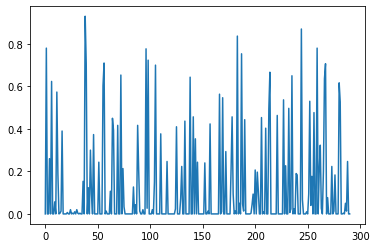

In [89]:
plt.plot(range(tpr*nrun), reg_success)

In [90]:
reg_movement = []
for ii in range(tpr*nrun):
    ## movement = integral dr = integral sqrt(dx*dx + dy*dy)
    XY = datum['allXY'][:,300*ii:300*(ii+1)]
    diff = np.diff(XY, axis=1)
    tmp = np.sum(diff*diff, axis=0)
    reg_movement.append(np.sqrt(tmp).sum())

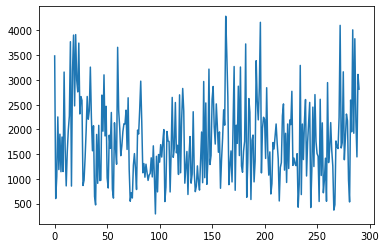

In [91]:
plt.plot(range(tpr*nrun), reg_movement)

In [92]:
reg_movement_normalized = normalize(np.reshape(reg_movement, (-1,1)), norm='l2', axis=0).reshape(-1)

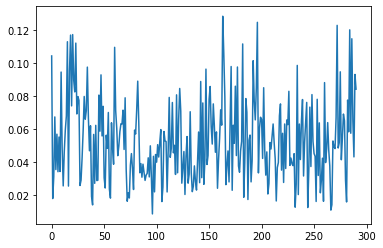

In [93]:
plt.plot(range(tpr*nrun), reg_movement_normalized)

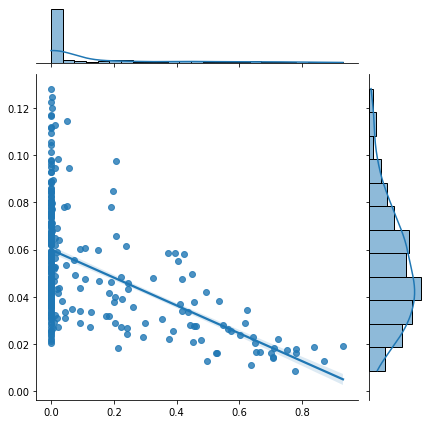

In [103]:
r, pval = stats.pearsonr(x=reg_movement_normalized, y=reg_success)

g = sns.jointplot(
    x = reg_success, y = reg_movement_normalized
    , kind="reg"
    , ci=68
)

---

100%|██████████| 36/36 [00:24<00:00,  1.47it/s]


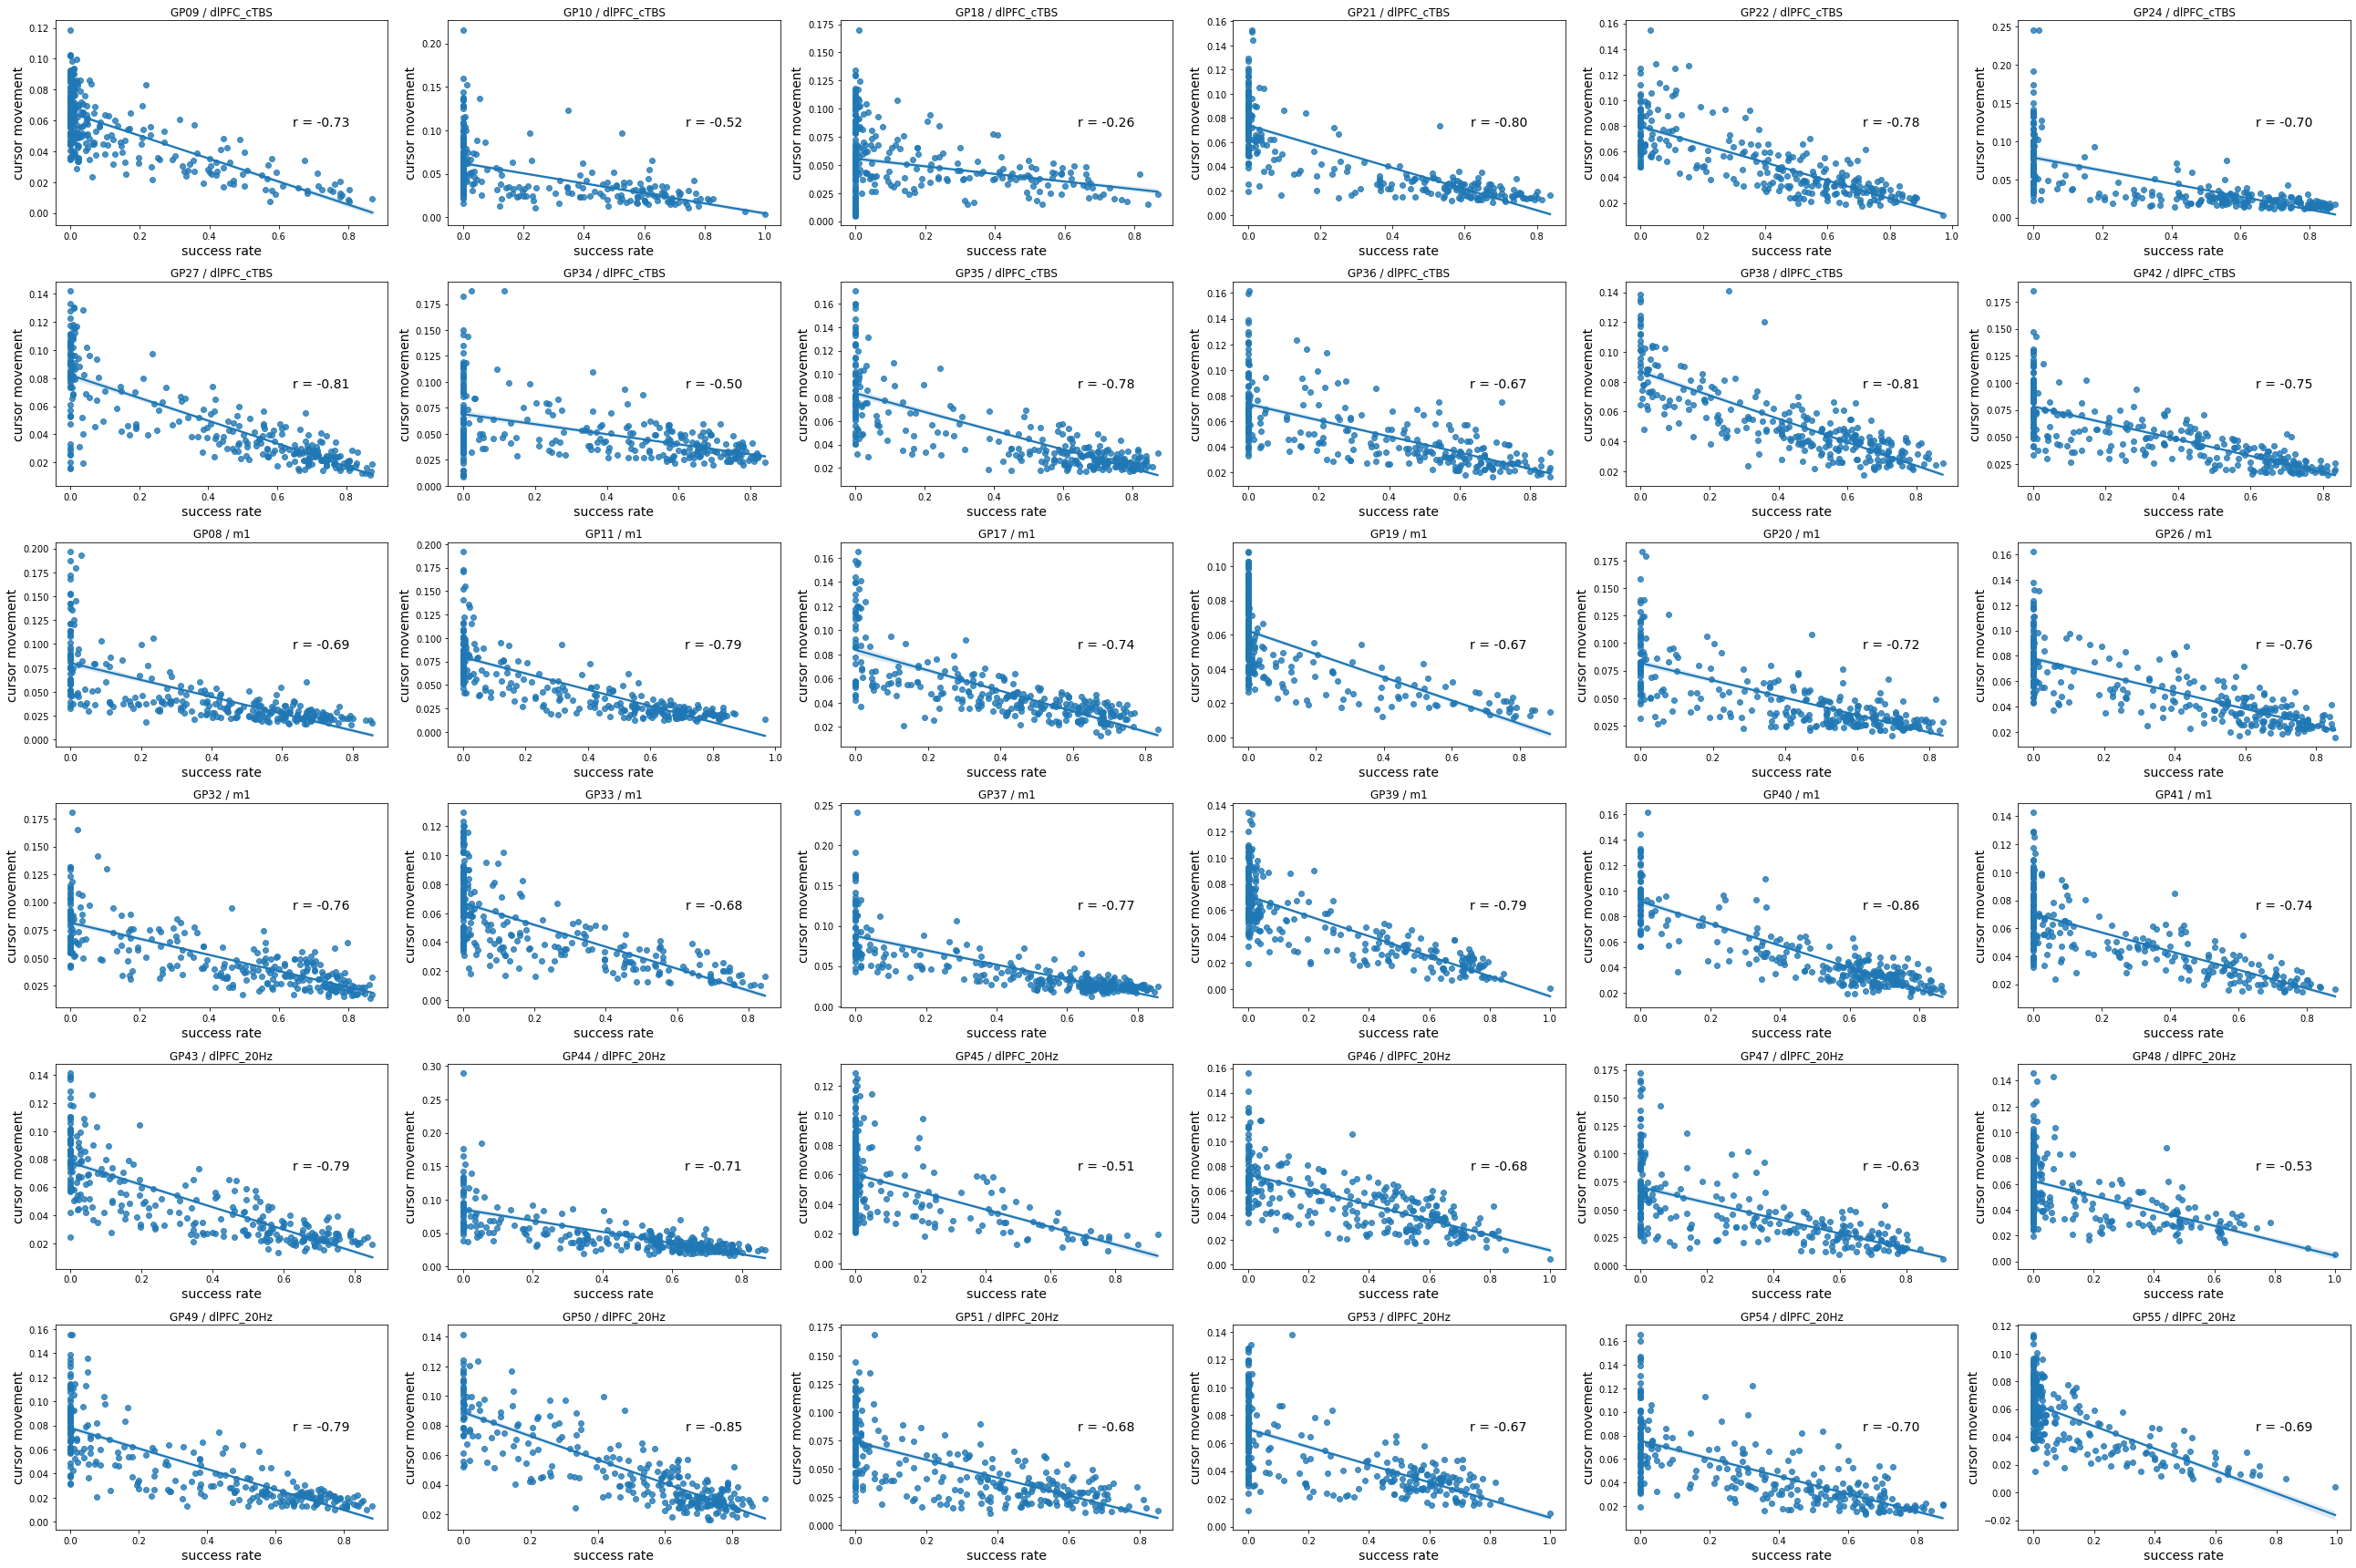

In [9]:
nrows, ncols = 6, 6
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*4))
axs = np.concatenate(axs)

for ii, nn in enumerate(tqdm(list_subj)):
    subj = 'GP'+nn
    group = 'dlPFC_cTBS' if nn in list_dlPFC_cTBS else ('dlPFC_20Hz' if nn in list_dlPFC_20 else ('m1' if nn in list_M1_cTBS else 'invalid'))

    behav_data = join(dir_behav, '%s-fmri.mat'%subj)
    datum = scipy.io.loadmat(behav_data)
    
    ## success rate
    hit = calc_hit(behav_data)
    reg_success = []
    for jj in range(tpr*nrun):
        reg_success.append(hit[300*jj:300*(jj+1)].sum())
    reg_success = np.array(reg_success)/300
    
    ## cursor movement
    reg_movement = []
    for jj in range(tpr*nrun):
        ## movement = integral dr = integral sqrt(dx*dx + dy*dy)
        XY = datum['allXY'][:,300*jj:300*(jj+1)]
        diff = np.diff(XY, axis=1)
        tmp = np.sum(diff*diff, axis=0)
        reg_movement.append(np.sqrt(tmp).sum())
        
    reg_movement_normalized = normalize(np.reshape(reg_movement, (-1,1)), norm='l2', axis=0).reshape(-1)
    
    r, pval = stats.pearsonr(x=reg_movement_normalized, y=reg_success)

    g = sns.regplot(
        x = reg_success, y = reg_movement_normalized
        , ci=68
        , ax=axs[ii]
    )
    g.set(title='%s / %s'%(subj, group))
    g.set_ylabel('cursor movement', fontsize=14)
    g.set_xlabel('success rate', fontsize=14)
    
    xlim = g.get_xlim()
    ylim = g.get_ylim()
    ## r = p * r1 + (1-p) * r2
    vec_o = np.array([xlim[0], ylim[0]])
    vec_x2 = np.array([xlim[1], ylim[0]])
    vec_y2 = np.array([xlim[0], ylim[1]])
    p = 0.8
    vec_x = (1-p) * vec_o + p * vec_x2
    p = 0.5
    vec_y = (1-p) * vec_o + p * vec_y2

    vec_r = np.array([vec_x[0], vec_y[1]])
    g.text(*vec_r, 'r = %.2f'%r, fontsize=14, va='center', ha='center')
    
fig.tight_layout()

---

In [11]:
shift = 2.5
dir_output = join(dir_reg, '%.1fs_shifted'%shift)

# shift = 5
# dir_output = join(dir_reg, '%dfs_shifted'%shift)

makedirs(dir_output, exist_ok=True)

In [12]:
for nn in tqdm(list_subj):
    subj = 'GP'+nn

    ## load data
    behav_data = join(dir_behav, '%s-fmri.mat'%subj)
    datum = scipy.io.loadmat(behav_data)

    ## construct a movement array, then normalize it
    reg_movement = []
    for ii in range(tpr*nrun):
        ## movement = integral dr , i.e., integral sqrt(dx*dx + dy*dy)
        XY = datum['allXY'][:,300*ii:300*(ii+1)]
        diff = np.diff(XY, axis=1)
        tmp = np.sum(diff*diff, axis=0)
        reg_movement.append(np.sqrt(tmp).sum())
    reg_movement_normalized = normalize(np.reshape(reg_movement, (-1,1)), norm='l2', axis=0).reshape(nrun,tpr)

    ## construct an onset time array,
    tmp = datum['LearnTrialStartTime'][0]
    tmp = np.diff(tmp)
    idx = np.where(tmp<0)[0] + 1

    onsettime = np.zeros((nrun, tpr), dtype=float)
    for rr in range(nrun):
        onsettime[rr,:] = datum['LearnTrialStartTime'][0][idx[rr]:idx[rr]+tpr]
    onsettime = onsettime * 0.001

    ## construct an AM2 regressor for movement
    regressor = [[],[],[]]
    for run in range(nrun):
        for trial, (onset, move) in enumerate(zip(onsettime[run], reg_movement_normalized[run])):
            regressor[run].append('%.2f*%.4f'%(onset+shift, move))

    ## save it
    np.savetxt(
        join(dir_output,'%s_movement.1D'%(subj)), regressor, fmt='%s'
        , delimiter=' ', newline='\n'
    )

100%|██████████| 36/36 [00:03<00:00, 11.28it/s]
